# KBG Syndrome

[KBG syndrome (KBGS)](https://omim.org/entry/148050) is caused by heterozygous mutation in the ANKRD11 gene. In this notebook, we have used
[pyphetools](https://github.com/monarch-initiative/pyphetools) to parse the clinical data included in the supplemental files of
[Martinez-Cayuelas E, et al. Clinical description, molecular delineation and genotype-phenotype correlation in 340 patients with KBG syndrome: addition of 67 new patients](https://pubmed.ncbi.nlm.nih.gov/36446582).

The authors identified a significantly higher frequency of patients with a triangular face in carriers of sequence variants compared to CNVs. Other associations found were short stature and variants in exon 9, a lower incidence of ID/ADHD/ASD in carriers of the c.1903_1907del variant and the size of the deletion, in CNV carriers, with the presence of macrodontia and hand anomalies.

In [1]:
import genophenocorr
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {genophenocorr.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.1.1dev


## Settings
Specify the transcript to be used to encode the variants (the phenopackets contain VCF representations of small variants).

### Pick transcript

We choose the [MANE Select](https://www.ncbi.nlm.nih.gov/nuccore/NM_013275.6) transcript for *ANKRD11*.

In [2]:
tx_id = 'NM_013275.6'

## Load Phenopackets

We will load phenopacket JSON files located in `phenopackets` folder that is next to the notebook.

In [3]:
from genophenocorr.preprocessing import configure_caching_cohort_creator, load_phenopacket_folder

fpath_phenopackets = 'phenopackets'
cohort_creator = configure_caching_cohort_creator(hpo, timeout=20)
cohort = load_phenopacket_folder(fpath_phenopackets, cohort_creator)



Patients Created: 100%|████████████████████████████████████████████████████| 337/337 [00:00<00:00, 407.92it/s]
Validated under none policy
Showing errors and warnings
337 phenopacket(s) found at `phenopackets`
  patient #0
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Novara, 2017_P2[PMID_36446582_Novara_2017_P2]. Remove variant from testing
     ·Patient PMID_36446582_Novara_2017_P2 has no variants to work with
  patient #1
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Goldenberg2016_P13[PMID_36446582_Goldenberg2016_P13]. Remove variant from testing
     ·Patient PMID_36446582_Goldenberg2016_P13 has no variants to work with
  patient #3
    variants
     warnings:
     ·Expected a VCF record, a VRS CNV, or an expression with `hgvs.c` but had an error retrieving any from patient Ockeloen2015_P

## Summarize the cohort

In [4]:
from IPython.display import display, HTML
from genophenocorr.view import CohortViewable

cv = CohortViewable(hpo=hpo)
html = cv.process(cohort=cohort, transcript_id=tx_id)

display(HTML(html))

HPO Term,ID,Annotation Count
Macrodontia,HP:0001572,211
Intellectual disability,HP:0001249,194
Abnormality of the hand,HP:0001155,189
Global developmental delay,HP:0001263,176
Delayed speech and language development,HP:0000750,160
Short stature,HP:0004322,150
Thick eyebrow,HP:0000574,126
Long philtrum,HP:0000343,121
Bulbous nose,HP:0000414,89
Triangular face,HP:0000325,83


In [5]:
from genophenocorr.preprocessing import UniprotProteinMetadataService
from genophenocorr.model.genome import GRCh38
from genophenocorr.preprocessing import VVTranscriptCoordinateService
pms = UniprotProteinMetadataService()
protein_meta = pms.annotate('NP_037407.4')
txc_service = VVTranscriptCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(tx_id)

In [6]:
from genophenocorr.view import ProteinVisualizable, ProteinVisualizer

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

<Axes: title={'center': 'Ankyrin repeat domain-containing protein 11\ntranscript: NM_013275.6, protein: NP_037407.4'}>

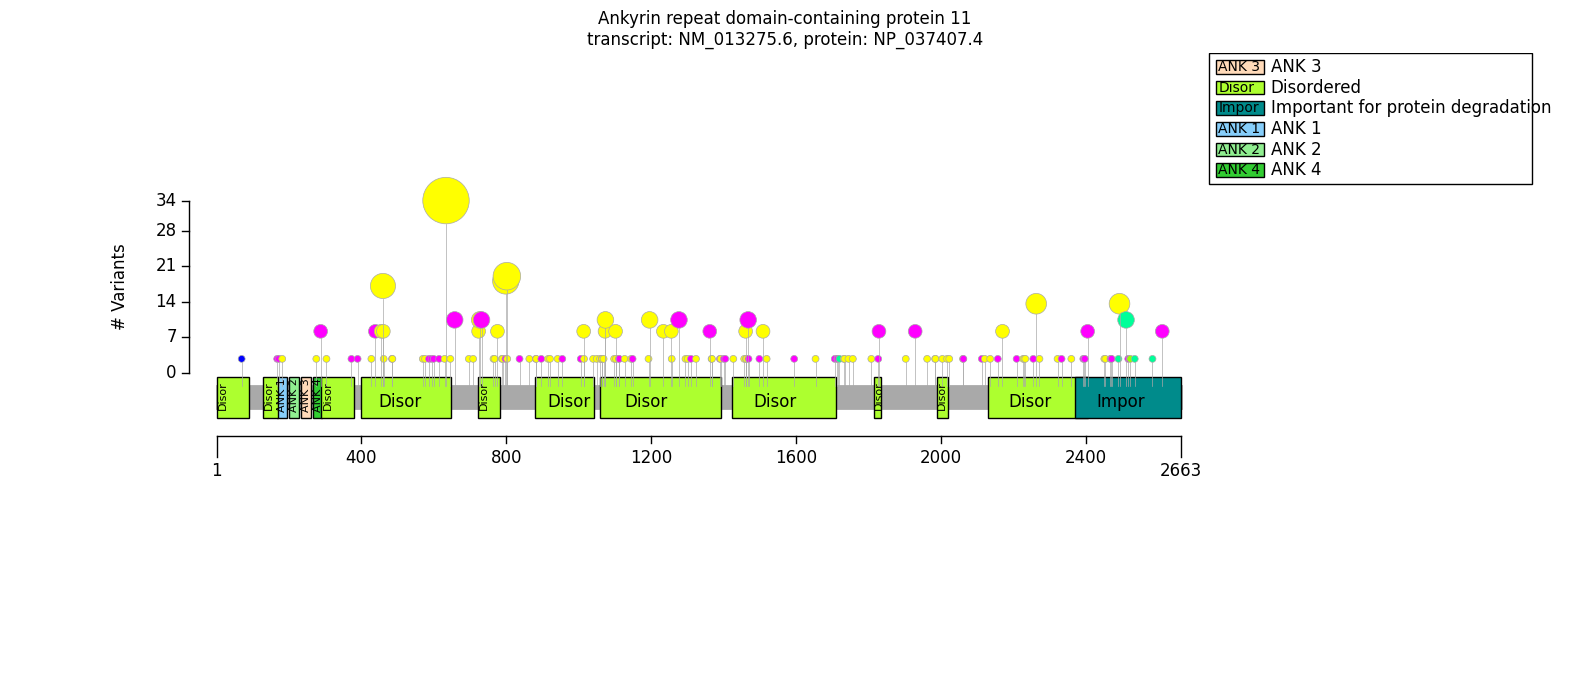

In [7]:
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

## Configure the analysis

In [8]:
from genophenocorr.analysis import configure_cohort_analysis, CohortAnalysisConfiguration
from genophenocorr.analysis.predicate import PatientCategories
from genophenocorr.model.genome import Region

analysis_config = CohortAnalysisConfiguration()
analysis_config.missing_implies_excluded = False
analysis_config.min_perc_patients_w_hpo = 0.1

analysis = configure_cohort_analysis(cohort, hpo, config=analysis_config)

Test for presence of genotype-phenotype correlations between frameshift variants vs. others.

In [9]:
from genophenocorr.model import VariantEffect

frameshift = analysis.compare_by_variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=tx_id)
frameshift.summarize(hpo, PatientCategories.YES)

FRAMESHIFT_VARIANT on NM_013275.6                     Yes             No  \
                                                    Count Percent  Count   
Abnormality of the hand [HP:0001155]               95/144     66%  60/71   
EEG abnormality [HP:0002353]                         7/33     21%   9/16   
Feeding difficulties [HP:0011968]                   33/89     37%  26/45   
Low anterior hairline [HP:0000294]                  40/58     69%  15/30   
Intellectual disability [HP:0001249]               99/119     83%  59/64   
...                                                   ...     ...    ...   
Abnormal muscle tone [HP:0003808]                   14/14    100%    7/7   
Growth delay [HP:0001510]                           75/75    100%  45/45   
Abnormality of head or neck [HP:0000152]          153/153    100%  74/74   
Non-motor seizure [HP:0033259]                        1/1    100%    2/2   
Abnormality of the frontal hairline [HP:0000599]    40/40    100%  15/15   

FRAMESHIFT_VARIANT on NM_013275.6                                   \
                                                 Percent   p value   
Abnormality of the hand [HP:0001155]                 85%  0.005661   
EEG abnormality [HP:0002353]                         56%  0.022884   
Feeding difficulties [HP:0011968]                    58%  0.027584   
Low anterior hairline [HP:0000294]                   50%  0.105274   
Intellectual disability [HP:0001249]                 92%  0.115195   
...                                                  ...       ...   
Abnormal muscle tone [HP:0003808]                   100%  1.000000   
Growth delay [HP:0001510]                           100%  1.000000   
Abnormality of head or neck [HP:0000152]            100%  1.000000   
Non-motor seizure [HP:0033259]                      100%  1.000000   
Abnormality of the frontal hairline [HP:0000599]    100%  1.000000   

FRAMESHIFT_VARIANT on NM_013275.6                                   
                                                 Corrected p value  
Abnormality of the hand [HP:0001155]                           1.0  
EEG abnormality [HP:0002353]                                   1.0  
Feeding difficulties [HP:0011968]                              1.0  
Low anterior hairline [HP:0000294]                             1.0  
Intellectual disability [HP:0001249]                           1.0  
...                                                            ...  
Abnormal muscle tone [HP:0003808]                              1.0  
Growth delay [HP:0001510]                                      1.0  
Abnormality of head or neck [HP:0000152]                       1.0  
Non-motor seizure [HP:0033259]                                 1.0  
Abnormality of the frontal hairline [HP:0000599]               1.0  

[190 rows x 6 columns]

Run the analysis with the HPO filter to reduce the number of tested phenotypes.

In [10]:
from genophenocorr.analysis import configure_cohort_analysis, CohortAnalysisConfiguration
from genophenocorr.analysis.predicate import PatientCategories

analysis_config = CohortAnalysisConfiguration()
analysis_config.missing_implies_excluded = False
analysis_config.min_perc_patients_w_hpo = 0.1
analysis_config.heuristic_strategy()
analysis = configure_cohort_analysis(cohort, hpo, config=analysis_config)

In [11]:
frameshift = analysis.compare_by_variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=tx_id)
frameshift.summarize(hpo, PatientCategories.YES)

FRAMESHIFT_VARIANT on NM_013275.6                       Yes             No  \
                                                      Count Percent  Count   
Abnormality of the hand [HP:0001155]                 95/144     66%  60/71   
EEG abnormality [HP:0002353]                           7/33     21%   9/16   
Feeding difficulties [HP:0011968]                     33/89     37%  26/45   
Low anterior hairline [HP:0000294]                    40/58     69%  15/30   
Intellectual disability [HP:0001249]                 99/119     83%  59/64   
Delayed skeletal maturation [HP:0002750]              37/86     43%  17/28   
Inguinal hernia [HP:0000023]                           2/31      6%   4/17   
Intrauterine growth retardation [HP:0001511]           6/39     15%   7/23   
Bulbous nose [HP:0000414]                             45/71     63%  29/39   
Hypertelorism [HP:0000316]                            34/63     54%  25/38   
Microretrognathia [HP:0000308]                        13/36     36%   3/16   
Sleep abnormality [HP:0002360]                        15/40     38%   4/17   
Short stature [HP:0004322]                           73/126     58%  42/65   
Delayed speech and language development [HP:000...    77/92     84%  44/49   
Exaggerated cupid's bow [HP:0002263]                  11/35     31%   2/12   
Mandibular prognathia [HP:0000303]                     8/33     24%   5/14   
Cryptorchidism [HP:0000028]                           20/51     39%  15/31   
Thick eyebrow [HP:0000574]                            68/82     83%  38/49   
Triangular face [HP:0000325]                          45/63     71%  23/36   
Microcephaly [HP:0000252]                             18/74     24%  12/39   
Motor delay [HP:0001270]                              36/52     69%  19/25   
Focal-onset seizure [HP:0007359]                        4/8     50%    4/6   
Low-set ears [HP:0000369]                             16/30     53%   5/11   
Recurrent otitis media [HP:0000403]                   17/36     47%   7/17   
Protruding ear [HP:0000411]                           32/44     73%  16/23   
Autistic behavior [HP:0000729]                        26/48     54%  14/24   
Macrodontia [HP:0001572]                            115/145     79%  55/68   
Attention deficit hyperactivity disorder [HP:00...    34/44     77%  19/24   
Generalized non-motor (absence) seizure [HP:000...      1/4     25%    2/4   
Hypotonia [HP:0001252]                                14/35     40%   7/18   
Prominent nose [HP:0000448]                           12/28     43%   5/13   
Anteverted nares [HP:0000463]                         41/58     71%  22/30   
Febrile seizure (within the age range of 3 mont...      3/5     60%    2/3   
Global developmental delay [HP:0001263]               86/91     95%  46/48   
Long philtrum [HP:0000343]                            66/82     80%  38/48   
Strabismus [HP:0000486]                               12/51     24%   4/19   
Generalized-onset seizure [HP:0002197]                  8/9     89%    4/5   

FRAMESHIFT_VARIANT on NM_013275.6                                     \
                                                   Percent   p value   
Abnormality of the hand [HP:0001155]                   85%  0.005661   
EEG abnormality [HP:0002353]                           56%  0.022884   
Feeding difficulties [HP:0011968]                      58%  0.027584   
Low anterior hairline [HP:0000294]                     50%  0.105274   
Intellectual disability [HP:0001249]                   92%  0.115195   
Delayed skeletal maturation [HP:0002750]               61%  0.128802   
Inguinal hernia [HP:0000023]                           24%  0.166824   
Intrauterine growth retardation [HP:0001511]           30%  0.202568   
Bulbous nose [HP:0000414]                              74%  0.291265   
Hypertelorism [HP:0000316]                             66%  0.299330   
Microretrognathia [HP:0000308]                         19%  0.330525   
Sleep abnormality [HP

In [12]:
from genophenocorr.view import StatsViewer

sv = StatsViewer()

stats_report = sv.process(frameshift.mtc_filter_report)

display(HTML(stats_report))

Reason,Count
Skipping term because all genotypes have same HPO observed proportions,124
Skipping top level term,12
Skipping term with only 3 observations (not powered for 2x2),8
Skipping term with only 6 observations (not powered for 2x2),5
Skipping term with only 5 observations (not powered for 2x2),2


Test for presence of genotype-phenotype correlations between subjects with >=1 allele of a variant vs. the other subjects:


In [13]:
var_single = analysis.compare_by_variant_key('16_89284634_89284639_GTGTTT_G')
var_single.summarize(hpo, PatientCategories.YES)

>=1 allele of the variant 16_89284634_89284639_GTGTTT_G    Yes          \
                                                         Count Percent   
Sleep abnormality [HP:0002360]                             7/9     78%   
Autistic behavior [HP:0000729]                             1/6     17%   
Intellectual disability [HP:0001249]                     14/19     74%   
Synophrys [HP:0000664]                                    5/14     36%   
EEG abnormality [HP:0002353]                               0/6      0%   
Low-set ears [HP:0000369]                                  5/6     83%   
Motor delay [HP:0001270]                                  6/11     55%   
Abnormality of the hand [HP:0001155]                     22/27     81%   
Recurrent otitis media [HP:0000403]                        2/7     29%   
Long philtrum [HP:0000343]                               12/13     92%   
Short stature [HP:0004322]                               12/23     52%   
Anteverted nares [HP:0000463]                             8/13     62%   
Bulbous nose [HP:0000414]                                10/13     77%   
Low anterior hairline [HP:0000294]                        7/13     54%   
Global developmental delay [HP:0001263]                  15/16     94%   
Mandibular prognathia [HP:0000303]                         2/5     40%   
Microretrognathia [HP:0000308]                             2/5     40%   
Attention deficit hyperactivity disorder [HP:00...         5/7     71%   
Exaggerated cupid's bow [HP:0002263]                       1/7     14%   
Protruding ear [HP:0000411]                                5/6     83%   
Hypotonia [HP:0001252]                                     2/7     29%   
Delayed speech and language development [HP:000...       13/16     81%   
Thick eyebrow [HP:0000574]                               10/13     77%   
Hypertelorism [HP:0000316]                                5/10     50%   
Feeding difficulties [HP:0011968]                         6/15     40%   
Delayed skeletal maturation [HP:0002750]                 10/20     50%   
Intrauterine growth retardation [HP:0001511]               1/7     14%   
Prominent nose [HP:0000448]                                2/4     50%   
Triangular face [HP:0000325]                               6/8     75%   
Microcephaly [HP:0000252]                                 4/16     25%   
Febrile seizure (within the age range of 3 mont...         1/1    100%   
Focal-onset seizure [HP:0007359]                           1/1    100%   
Inguinal hernia [HP:0000023]                               0/4      0%   
Cryptorchidism [HP:0000028]                               5/12     42%   
Macrodontia [HP:0001572]                                 22/27     81%   
Strabismus [HP:0000486]                                   2/10     20%   

>=1 allele of the variant 16_89284634_89284639_GTGTTT_G       No          \
                                                           Count Percent   
Sleep abnormality [HP:0002360]                             12/48     25%   
Autistic behavior [HP:0000729]                             39/66     59%   
Intellectual disability [HP:0001249]                     144/164     88%   
Synophrys [HP:0000664]                                     48/82     59%   
EEG abnormality [HP:0002353]                               16/43     37%   
Low-set ears [HP:0000369]                                  16/35     46%   
Motor delay [HP:0001270]                                   49/66     74%   
Abnormality of the hand [HP:0001155]                     133/188     71%   
Recurrent otitis media [HP:0000403]                        22/46     48%   
Long philtrum [HP:0000343]                                92/117     79%   
Short stature [HP:0004322]                               103/168     61%   
Anteverted nares [HP:0000463]                              55/75     73%   
Bulbous nose [HP:0000414]                                  64/97     66%   
Low anterior hairline [HP:0000294]             

Or between subjects with one variant vs. the other variant.

In [14]:
var_double = analysis.compare_by_exon(9, tx_id)
var_double.summarize(hpo, PatientCategories.YES)

Variant in exon 9 on NM_013275.6                        Yes             No  \
                                                      Count Percent  Count   
Abnormality of the hand [HP:0001155]                134/191     70%  21/24   
Intellectual disability [HP:0001249]                135/159     85%  23/24   
Autistic behavior [HP:0000729]                        30/58     52%  10/14   
Triangular face [HP:0000325]                          54/82     66%  14/17   
Long philtrum [HP:0000343]                           96/118     81%   8/12   
Bulbous nose [HP:0000414]                             65/99     66%   9/11   
Synophrys [HP:0000664]                                48/84     57%   5/12   
Short stature [HP:0004322]                          103/167     62%  12/24   
Prominent nose [HP:0000448]                           16/36     44%    1/5   
Exaggerated cupid's bow [HP:0002263]                  12/39     31%    1/8   
Hypotonia [HP:0001252]                                19/45     42%    2/8   
Focal-onset seizure [HP:0007359]                       6/12     50%    2/2   
Delayed skeletal maturation [HP:0002750]             49/106     46%    5/8   
Recurrent otitis media [HP:0000403]                   18/43     42%   6/10   
Motor delay [HP:0001270]                              46/66     70%   9/11   
Global developmental delay [HP:0001263]             120/126     95%  12/13   
Cryptorchidism [HP:0000028]                           29/71     41%   6/11   
Feeding difficulties [HP:0011968]                    52/121     43%   7/13   
Delayed speech and language development [HP:000...  112/130     86%   9/11   
Sleep abnormality [HP:0002360]                        17/48     35%    2/9   
Microretrognathia [HP:0000308]                        14/43     33%    2/9   
Anteverted nares [HP:0000463]                         55/78     71%   8/10   
Microcephaly [HP:0000252]                            27/103     26%   3/10   
Protruding ear [HP:0000411]                           40/55     73%   8/12   
Hypertelorism [HP:0000316]                            52/90     58%   7/11   
Low anterior hairline [HP:0000294]                    47/74     64%   8/14   
Macrodontia [HP:0001572]                            150/189     79%  20/24   
Attention deficit hyperactivity disorder [HP:00...    41/53     77%  12/15   
Intrauterine growth retardation [HP:0001511]          11/52     21%   2/10   
Mandibular prognathia [HP:0000303]                    11/38     29%    2/9   
Low-set ears [HP:0000369]                             19/37     51%    2/4   
Inguinal hernia [HP:0000023]                           5/38     13%   1/10   
Strabismus [HP:0000486]                               14/62     23%    2/8   

Variant in exon 9 on NM_013275.6                                      \
                                                   Percent   p value   
Abnormality of the hand [HP:0001155]                   88%  0.091823   
Intellectual disability [HP:0001249]                   96%  0.207310   
Autistic behavior [HP:0000729]                         71%  0.237414   
Triangular face [HP:0000325]                           82%  0.254000   
Long philtrum [HP:0000343]                             67%  0.256572   
Bulbous nose [HP:0000414]                              82%  0.335152   
Synophrys [HP:0000664]                                 42%  0.363313   
Short stature [HP:0004322]                             50%  0.372557   
Prominent nose [HP:0000448]                            20%  0.382245   
Exaggerated cupid's bow [HP:0002263]                   12%  0.413327   
Hypotonia [HP:0001252]                                 25%  0.454995   
Focal-onset seizure [HP:0007359]                      100%  0.472527   
Delayed skeletal maturation [HP:0002750]               62%  0.473629   
Recurrent otitis media [HP:0000403]                    60%  0.482277   
Motor delay [HP:0001270]                               82%  0.497213   
Global developmental delay [HP:0001263]      

In [15]:
prot_test = analysis.compare_by_protein_feature('Important for protein degradation', tx_id)
prot_test.summarize(hpo,PatientCategories.YES)

Variant that affects Important for protein degradation feature on protein encoded by transcript NM_013275.6    Yes  \
                                                                                                             Count   
Intrauterine growth retardation [HP:0001511]                                                                   4/8   
Inguinal hernia [HP:0000023]                                                                                   2/6   
Autistic behavior [HP:0000729]                                                                                8/10   
EEG abnormality [HP:0002353]                                                                                   3/5   
Hypertelorism [HP:0000316]                                                                                    9/12   
Short stature [HP:0004322]                                                                                   11/22   
Febrile seizure (within the age range of 3 mont...                                                             0/1   
Macrodontia [HP:0001572]                                                                                     15/21   
Recurrent otitis media [HP:0000403]                                                                            4/6   
Abnormality of the hand [HP:0001155]                                                                         17/21   
Synophrys [HP:0000664]                                                                                         3/8   
Low anterior hairline [HP:0000294]                                                                             4/8   
Bulbous nose [HP:0000414]                                                                                     8/10   
Feeding difficulties [HP:0011968]                                                                             7/13   
Strabismus [HP:0000486]                                                                                        2/7   
Delayed speech and language development [HP:000...                                                            9/11   
Motor delay [HP:0001270]                                                                                       6/7   
Delayed skeletal maturation [HP:0002750]                                                                       2/6   
Microcephaly [HP:0000252]                                                                                     3/10   
Long philtrum [HP:0000343]                                                                                   12/14   
Triangular face [HP:0000325]                                                                                  7/11   
Intellectual disability [HP:0001249]                                                                         20/22   
Cryptorchidism [HP:0000028]                                                                                   6/12   
Exaggerated cupid's bow [HP:0002263]                                                                           1/5   
Thick eyebrow [HP:0000574]                                                                                   12/15   
Microretrognathia [HP:0000308]                                                                                 1/5   
Generalized non-motor (absence) seizure [HP:000...                                                             1/2   
Hypotonia [HP:0001252]                                                                                         3/7   
Prominent nose [HP:0000448]                                                                                    2/4   
Mandibular prognathia [HP:0000303]                                                                             1/5   
Anteverted nares [HP:0000463]                                                                                  7/9   
Sleep abnormality [HP:0002360]                                                                            

In [18]:
prot_test = analysis.compare_by_protein_region(Region(400, 800), tx_id)
prot_test.summarize(hpo,PatientCategories.YES)

Variant that affects Region(start=400, end=800) region on protein encoded by transcript NM_013275.6    Yes  \
                                                                                                     Count   
Hypertelorism [HP:0000316]                                                                           11/29   
Autistic behavior [HP:0000729]                                                                        6/17   
Long philtrum [HP:0000343]                                                                           35/39   
Sleep abnormality [HP:0002360]                                                                        9/19   
Febrile seizure (within the age range of 3 mont...                                                     3/3   
Anteverted nares [HP:0000463]                                                                        20/32   
Hypotonia [HP:0001252]                                                                                9/17   
Strabismus [HP:0000486]                                                                               8/25   
Macrodontia [HP:0001572]                                                                             52/69   
Focal-onset seizure [HP:0007359]                                                                       2/2   
Prominent nose [HP:0000448]                                                                           6/11   
Exaggerated cupid's bow [HP:0002263]                                                                  5/14   
Generalized-onset seizure [HP:0002197]                                                                 3/4   
Microcephaly [HP:0000252]                                                                             9/41   
Abnormality of the hand [HP:0001155]                                                                 55/73   
Feeding difficulties [HP:0011968]                                                                    18/45   
Cryptorchidism [HP:0000028]                                                                          10/26   
Triangular face [HP:0000325]                                                                         21/29   
Global developmental delay [HP:0001263]                                                              46/49   
Delayed skeletal maturation [HP:0002750]                                                             20/40   
Microretrognathia [HP:0000308]                                                                        5/14   
EEG abnormality [HP:0002353]                                                                          4/15   
Low-set ears [HP:0000369]                                                                             6/13   
Recurrent otitis media [HP:0000403]                                                                   8/16   
Motor delay [HP:0001270]                                                                             17/25   
Delayed speech and language development [HP:000...                                                   42/48   
Low anterior hairline [HP:0000294]                                                                   16/27   
Thick eyebrow [HP:0000574]                                                                           33/40   
Synophrys [HP:0000664]                                                                               19/33   
Bulbous nose [HP:0000414]                                                                            25/38   
Attention deficit hyperactivity disorder [HP:00...                                                   13/17   
Generalized non-motor (absence) seizure [HP:000...                                                     0/1   
Intrauterine growth retardation [HP:0001511]                                                          3/16   
Protruding ear [HP:0000411]                                                                          14/19   
Mandibular prognathia [HP:0000303]      

TODO - finalize!